# Face recogintion

## Problem Statement
We intend to perform face recognition. face recognition means that for a given image you can tell the subject id. Our database of subjects is very simple. It has 40 subjects.

We will start by connecting google drive to our notebook, we will need it to load kaggle config and download our dataset into.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Next, we will load our config file to be able to use kaggle's api.

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
# changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


## 1) Download the dataset

In [ ]:
# to not download the dataset each time we run this notebook
downloaded = True 
if not downloaded:
    !kaggle datasets download -d kasikrit/att-database-of-faces
    
    # unzipping the zip files and deleting the zip files
    ! unzip att-database-of-faces.zip -d att-database-of-faces

Lets now load our libraries.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Now we can load our dataset, generate our data matrix, and create a dataframe using the data matrix.

## 2) Generate the Data Matrix, the Label vector, and understanding the format.

In [ ]:
def load_data(data_path):
    image_dir = []    # contains all the images directories
    subject = []    # contains the corresponding subject number for each image
    image_id = []    # contains the image id 
    image_vector = []    # contain the flattened images

    for folder in os.listdir(data_path):
        # it is not a folder so we will have to skip it.
        if folder == "README":
            continue
        
        for image in os.listdir(data_path + folder):
            current_image_dir = data_path + folder + '/' + image
            image_dir.append(current_image_dir)
            subject.append(folder[1:])
            image_id.append(image.split(".")[0])
            # we will read the images in greyscale hence cv2.imread(_, 0)
            image_vector.append(cv2.imread(current_image_dir, 0).flatten())


    data_df = pd.DataFrame(image_vector)
    data_df['image_dir'] = image_dir
    data_df['subject'] = subject
    data_df['id'] = image_id

    return data_df

data_path = './att-database-of-faces/'
data_df = load_data(data_path)

In [ ]:
# taking a quick look at our dataframe
print(data_df.shape)
data_df.head()

(400, 10307)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10267,10268,10269,10270,10271,10272,10273,10274,10275,10276,10277,10278,10279,10280,10281,10282,10283,10284,10285,10286,10287,10288,10289,10290,10291,10292,10293,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303,image_dir,subject,id
0,48,49,45,47,49,57,39,42,53,49,53,60,76,91,99,95,80,75,66,54,47,49,50,43,46,53,61,70,84,105,133,130,110,94,81,107,95,80,57,55,...,145,148,144,144,148,145,152,146,159,170,174,172,171,173,172,170,166,161,150,154,141,57,19,26,31,42,34,39,44,40,41,49,42,44,47,46,46,./att-database-of-faces/s1/1.pgm,1,1
1,39,44,53,37,61,48,61,45,35,40,40,39,55,84,110,96,73,72,86,103,86,88,82,77,75,88,90,123,91,94,103,105,101,97,109,108,111,120,125,131,...,148,151,153,150,147,145,143,144,146,140,121,102,91,84,77,65,48,35,26,31,32,32,33,35,39,37,44,23,30,36,32,28,32,31,29,26,29,./att-database-of-faces/s1/3.pgm,1,3
2,63,53,35,36,33,34,31,35,39,43,56,72,76,79,77,82,80,81,89,92,85,85,92,96,104,110,121,132,139,143,142,151,160,163,170,160,160,162,166,168,...,140,134,150,158,165,170,168,183,169,171,180,174,169,177,168,171,166,171,174,183,178,181,182,183,178,183,178,173,169,166,161,158,169,137,41,10,24,./att-database-of-faces/s1/4.pgm,1,4
3,34,34,33,32,38,40,39,49,54,57,65,72,85,74,66,62,68,72,73,67,71,53,56,76,80,65,66,48,34,41,39,45,45,53,60,87,120,130,129,140,...,131,135,147,154,159,169,166,164,165,164,163,158,135,89,58,63,42,18,22,29,32,37,38,37,44,46,33,42,44,38,30,37,30,36,37,40,33,./att-database-of-faces/s1/10.pgm,1,10
4,60,60,62,53,48,51,61,60,71,68,78,72,71,74,78,88,88,77,83,92,95,100,114,122,119,126,136,138,143,143,147,145,145,143,151,148,150,149,150,151,...,148,145,149,142,137,133,131,125,123,126,134,144,137,145,142,140,143,138,137,143,97,32,17,21,31,34,43,27,35,28,33,31,31,37,32,34,34,./att-database-of-faces/s1/2.pgm,1,2


Each row contains the image in the form of a vector, its subject number, its directory, and its id. 

Let us now take a look at a random image from our dataframe.

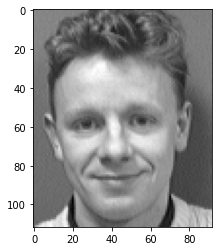

In [ ]:
# generate a random number between 0 and 399
n = np.random.randint(data_df.shape[0])
# get the random image directory and load it
img = cv2.imread(data_df["image_dir"][n], 0)
plt.imshow(img, cmap='gray')

## 3) Split the Dataset into train and test sets

We can now split our data into 2 halves, a train set and a test set.
We will split the odd rows for training and the even rows for testing.

In [ ]:
train = data_df[1::2]
test = data_df[::2]

# drop the unnecessary columns from our train set features
X_train = train.iloc[:,:-3]
# create our train set labels
y_train = train['subject']

# drop the unnecessary columns from our test set features
X_test = test.iloc[:,:-3]
# create our test set labels
y_test = test['subject']

print(data_df.shape)
print(X_test.shape)
print(y_train.shape)

(400, 10307)
(200, 10304)
(200,)


In [ ]:
# lets check the frequency and the count in our data set after the split
y_train.describe()

count     200
unique     40
top         5
freq        5
Name: subject, dtype: object

## 4) Classification using PCA

We will implement PCA from scratch, we will not use it in comparisons as it is not as optimized as the scikit-learn PCA but it returns the same result. (due to the use of np.linalg.eig which roughly takes on average 900 sec per run)

In [ ]:
def pca(X, alpha=1, components=[], mode=1):
    print("PCA")

    m = np.mean(X, axis=0)  # compute mean
    Z = X - m   # center the data
    print("data centered!")
    print(X.shape)

    if mode:
        print(".FIT_TRANSFORM() MODE!!!")
        cov_matrix = np.dot(Z.T, Z)/Z.shape[0]
        #cov_matrix = np.cov(Z , rowvar = False)
        print("Cov Matrix")
        e_values, e_vectors = np.linalg.eig(cov_matrix)
        print("eigens done!")
        sorted_index = np.argsort(e_values)[::-1]
        print("sorted!")
        e_values = e_values[sorted_index]
        e_vectors = e_vectors[:,sorted_index]
        e_values_sum = e_values.sum()
        
        r = 0
        i = 0
        print("alpha: ", alpha)
        while (r < alpha):
            #print("r: ", r, "i: ", i)
            curr_var = e_values[i] / e_values_sum
            r += curr_var
            i += 1
        e_vectors_subset = e_vectors[:,:i]
        #print(e_values[:i])
    else:
        print(".TRANSFORM() MODE!!!")
        e_vectors_subset = components


    #print(e_vectors_subset)
    reduced_X = np.dot(e_vectors_subset.transpose(), Z.transpose()).transpose()

    return reduced_X.real, e_vectors_subset


from sklearn.neighbors import KNeighborsClassifier

alpha = [0.8, 0.85, 0.9, 0.95]
acc = []
for a in alpha:
    X_train_transformed, components = pca(X_train, alpha=a)
    #print(X_train_transformed.shape)
    neigh = KNeighborsClassifier(n_neighbors=3)

    neigh.fit(X_train_transformed, y_train)

    # transform new data using already fitted pca
    # (we do not need to re-fit the pca)
    X_test_transformed, _ = pca(X_test, alpha=a, components=components, mode=0)

    # predict labels using the trained classifier
    y_pred = neigh.predict(X_test_transformed)

    from sklearn.metrics import accuracy_score
    acc.append(accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

alpha = np.arange(0.8, 1, 0.05)
acc_alpha_50 = []
for a in alpha:
    pca = PCA(n_components=a)
    X_train_transformed = pca.fit_transform(X_train)
    #print(pca.components_)
    #print(pca.components_.shape)
    #print(X_train_transformed.shape)
    neigh = KNeighborsClassifier(n_neighbors=3)

    neigh.fit(X_train_transformed, y_train)

    # transform new data using already fitted pca
    # (we do not need to re-fit the pca)
    X_test_transformed = pca.transform(X_test)

    # predict labels using the trained classifier

    y_pred = neigh.predict(X_test_transformed)

    ac = accuracy_score(y_test, y_pred)
    acc_alpha_50.append(ac)
    print(a, ac)

0.8 0.89
0.8500000000000001 0.9
0.9000000000000001 0.89
0.9500000000000002 0.89


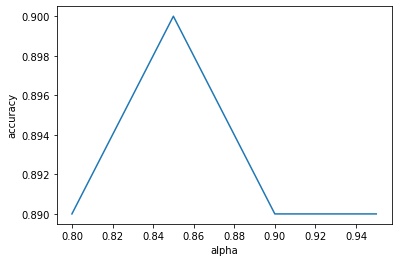

In [ ]:
plt.plot(alpha, acc_alpha_50)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.show()

As alpha increase, the model's accuracy starts to get better, then after alpha = 0.85, our model start to overfit on our dataset.

## 6) Classifier Tuning

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


kn = np.arange(1, 9, 2)
# alpha = np.arange(0.8, 1, 0.05)
alpha = [0.85]

acc_k_50 = []
for k in kn:
    for a in alpha:
        pipe = Pipeline([('pca', PCA(n_components=a)),
                        ('knn', KNeighborsClassifier(n_neighbors=k))])

        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)

        ac = accuracy_score(y_test, y_pred)
        acc_k_50.append(ac)
        print("k: {}, alpha: {}, acc: {}".format(k, a, ac))

k: 1, alpha: 0.85, acc: 0.96
k: 3, alpha: 0.85, acc: 0.9
k: 5, alpha: 0.85, acc: 0.835
k: 7, alpha: 0.85, acc: 0.795


Text(0, 0.5, 'accuracy')

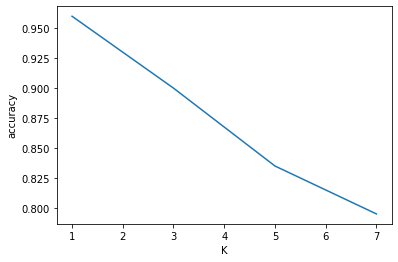

In [ ]:
plt.plot(kn, acc_k_50)
plt.xlabel('K size')
plt.ylabel('accuracy')

Our Knn Model's tie breaking strategy is to take the result depending on their order in the training data.
<br>
As we increase our K, our model's accuracy decreases.

## 7) Bonus
Change the number ofinstances per subject to be 7 and keep 3 instances per subject for testing.compare the results you have with the ones you got earlier with 50% split.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_df, test_size=0.3, random_state=42, stratify=data_df["subject"])

In [ ]:
X_train = train.iloc[:,:-3]
y_train = train['subject']

X_test = test.iloc[:,:-3]
y_test = test['subject']

print(data_df.shape)
print(X_test.shape)
print(y_train.shape)

(400, 10307)
(120, 10304)
(280,)


In [ ]:
y_train.describe()

count     280
unique     40
top         5
freq        7
Name: subject, dtype: object

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

alpha = np.arange(0.8, 1, 0.05)
acc_alpha_70 = []
for a in alpha:
    pca = PCA(n_components=a)
    X_train_transformed = pca.fit_transform(X_train)
    #print(pca.components_)
    #print(pca.components_.shape)
    #print(X_train_transformed.shape)
    neigh = KNeighborsClassifier(n_neighbors=3)

    neigh.fit(X_train_transformed, y_train)

    # transform new data using already fitted pca
    # (we do not need to re-fit the pca)
    X_test_transformed = pca.transform(X_test)

    # predict labels using the trained classifier

    y_pred = neigh.predict(X_test_transformed)

    ac = accuracy_score(y_test, y_pred)
    acc_alpha_70.append(ac)
    print(a, ac)

0.8 0.9583333333333334
0.8500000000000001 0.9416666666666667
0.9000000000000001 0.9416666666666667
0.9500000000000002 0.9333333333333333


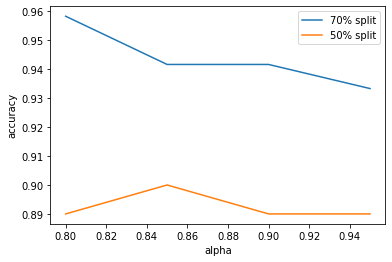

In [ ]:
plt.plot(alpha, acc_alpha_70, label="70% split")
plt.plot(alpha, acc_alpha_50, label="50% split")
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


kn = np.arange(1, 9, 2)
# alpha = np.arange(0.8, 1, 0.05)
alpha = [0.85]

acc_k_70 = []
for k in kn:
    for a in alpha:
        pipe = Pipeline([('pca', PCA(n_components=a)),
                        ('knn', KNeighborsClassifier(n_neighbors=k))])

        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)

        ac = accuracy_score(y_test, y_pred)
        acc_k_70.append(ac)
        print("k: {}, alpha: {}, acc: {}".format(k, a, ac))

k: 1, alpha: 0.85, acc: 0.9916666666666667
k: 3, alpha: 0.85, acc: 0.9416666666666667
k: 5, alpha: 0.85, acc: 0.8916666666666667
k: 7, alpha: 0.85, acc: 0.8666666666666667


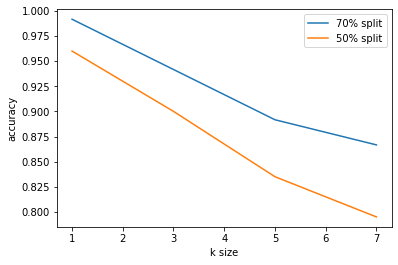

In [ ]:
plt.plot(kn, acc_k_70, label="70% split")
plt.plot(kn, acc_k_50, label="50% split")
plt.xlabel('k size')
plt.ylabel('accuracy')
plt.legend()
plt.show()